In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Import data
birth = pd.read_csv("/Users/AnhHuynh/Documents/Data Analyst portfolio/Projects/Time Series/daily-total-female-births-in-cal.csv", index_col=[0], parse_dates=[0])

#parse_dates = [0]: we give pandas a hint that data in the 1st col contains dates that needs to be parsed
#index_col=[0]: we set the first col as index
#squeeze: convert a single col DF into a Series, meaning rows contain scalar values

In [77]:
# Data overview
birth.head()

,"Daily total female births in California, 1959"
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


* When working with Time Series, it's better to use Series instead of DF
* However, since we will perform some EDA first, we need to the format as DF for now. After that, we can covert the data into Series using value method.

In [78]:
series_value = pd.Series(birth['Daily total female births in California, 1959'])

In [79]:
type(series_value)

pandas.core.series.Series

In [80]:
# Check for null values
birth.tail()

,"Daily total female births in California, 1959"
Date,
1959-12-27,37
1959-12-28,52
1959-12-29,48
1959-12-30,55
1959-12-31,50


* We see that the last value of the dataset is not number of births of the year. We need to fix this or it will cause misleading prediction later on.

In [81]:
birth = birth [0:365]

In [82]:
birth.describe()

,"Daily total female births in California, 1959"
count,365.000000
mean,41.980822
std,7.348257
min,23.000000
25%,37.000000
50%,42.000000
75%,46.000000
max,73.000000


<AxesSubplot:xlabel='Date'>

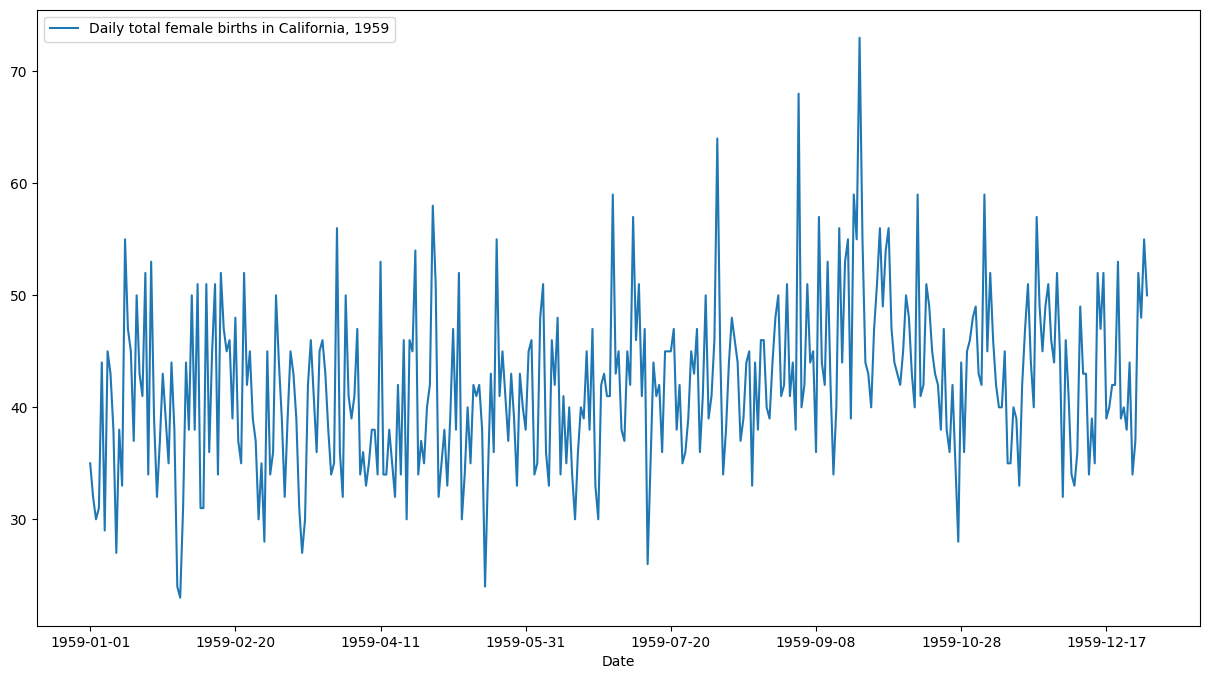

In [83]:
birth.plot(figsize=(15,8))

There is no clear trend or seasonality detected in the data based on the graph

In [84]:
# Calculating 20 days moving average of births

birth_mv = birth.rolling(window=20).mean()

<AxesSubplot:xlabel='Date'>

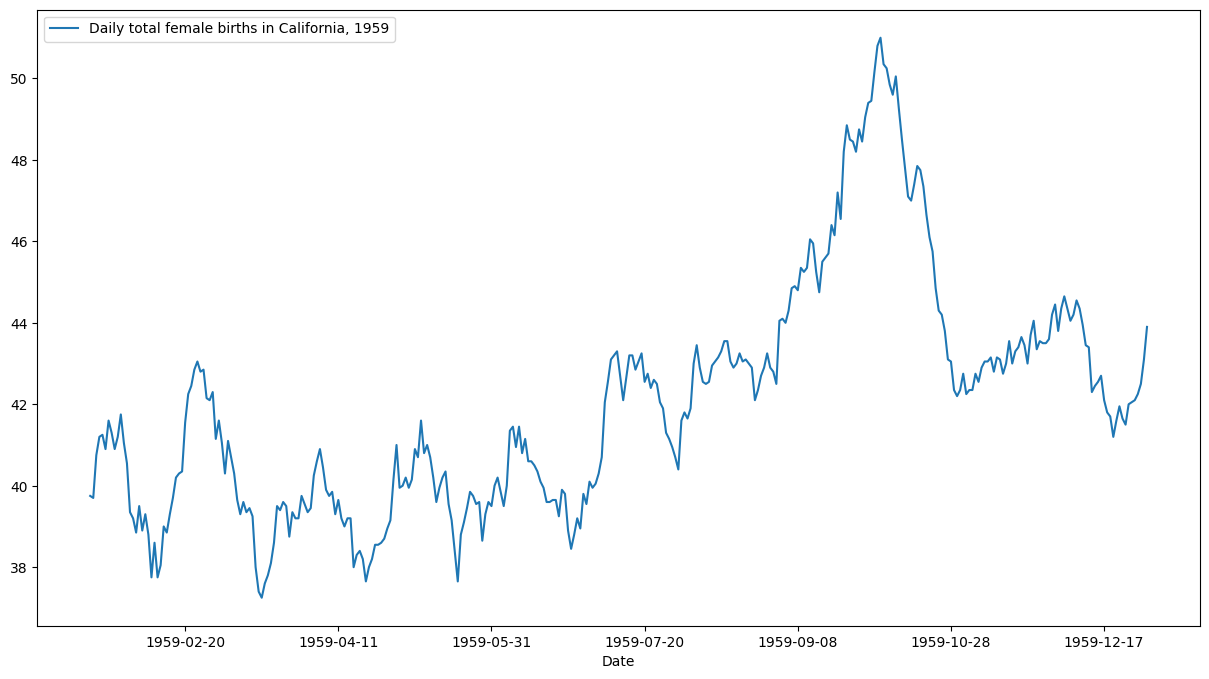

In [85]:
birth_mv.plot(figsize=(15,8))

The moving average plot shows a slight upward trend when we perform 1-level moving average

In [86]:
value = pd.DataFrame(series_value)

In [87]:
birth_df = pd.concat([value, value.shift(1)],axis=1)

# We want to do the lags (shift(1)). But shift() only works for Dataframe, not np.array, that's why we need to create a birth DF

In [88]:
birth_df.columns = ['t', 't+1']

In [89]:
birth_df

,t,t+1
Date,,
1959-01-01,35,NaN
1959-01-02,32,35.0
1959-01-03,30,32.0
1959-01-04,31,30.0
1959-01-05,44,31.0
...,...,...
1959-12-27,37,34.0
1959-12-28,52,37.0
1959-12-29,48,52.0


In [90]:
from sklearn.metrics import mean_squared_error

In [91]:
birth_test = birth_df[1:]

In [92]:
birth_test

,t,t+1
Date,,
1959-01-02,32,35.0
1959-01-03,30,32.0
1959-01-04,31,30.0
1959-01-05,44,31.0
1959-01-06,29,44.0
...,...,...
1959-12-27,37,34.0
1959-12-28,52,37.0
1959-12-29,48,52.0


In [93]:
birth_test = birth_test[0:364]

In [94]:
birth_error = mean_squared_error(birth_test['t'], birth_test['t+1'])

In [95]:
from math import sqrt
sqrt(birth_error)

9.177283229394606

## ARIMA: Autoregressive (p) Integrated (d) Moving Average (q) 

* d: level of differences

In [96]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

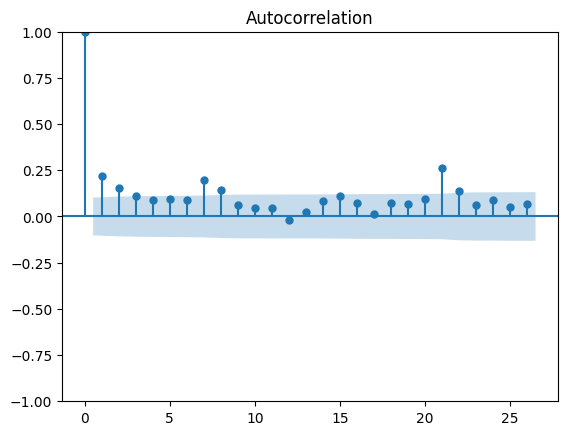

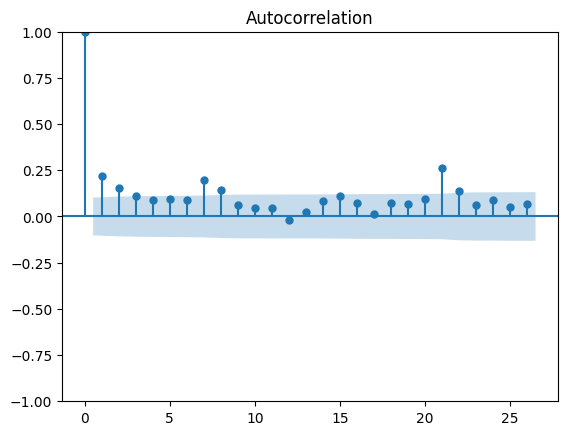

In [97]:
# Plot acf to identify parameter q (autoregressive)
plot_acf(birth)

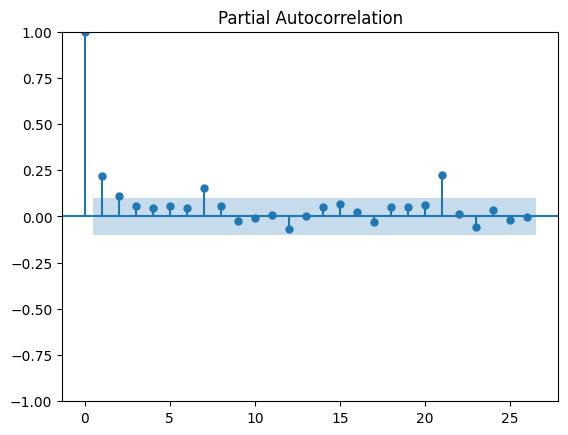

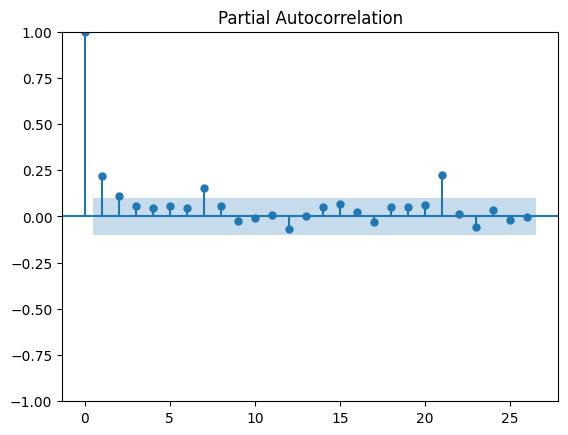

In [98]:
plot_pacf(birth) # to identify the value of p

In [24]:
birth.size

365

In [63]:
type(birth)

pandas.core.frame.DataFrame

In [99]:
series_value

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
              ..
1959-12-27    37
1959-12-28    52
1959-12-29    48
1959-12-30    55
1959-12-31    50
Name: Daily total female births in California, 1959, Length: 365, dtype: int64

In [124]:
import random
random.seed(345)
birth_train = series_value[0:330]
birth_test = series_value[330:365]

In [126]:
print(birth_train.size)
print(birth_test.size)

330
35


In [127]:
from statsmodels.tsa.arima.model import ARIMA

In [154]:
birth_model = ARIMA(birth_train, order=(1,1,1))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [155]:
birth_model_fit = birth_model.fit()

In [156]:
birth_model_fit.aic

# aic quantifies the goodness of fit. The lower the aic, the better the model

2228.0930224379963

In [165]:
y_pred = birth_model_fit.get_forecast(len(birth_test.index))

In [166]:
y_pred_df = y_pred.conf_int(alpha=0.5)
y_pred_df

,"lower Daily total female births in California, 1959","upper Daily total female births in California, 1959"
1959-11-27,40.185718,49.710632
1959-11-28,39.687604,49.319203
1959-11-29,39.631191,49.277970
1959-11-30,39.620739,49.277703
1959-12-01,39.615306,49.281959
1959-12-02,39.610428,49.286708
1959-12-03,39.605615,49.291507
1959-12-04,39.600814,49.296307
1959-12-05,39.596017,49.301103
1959-12-06,39.591226,49.305894


In [167]:
y_pred_df['Predictions'] = birth_model_fit.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])

In [168]:
y_pred_df

,"lower Daily total female births in California, 1959","upper Daily total female births in California, 1959",Predictions
1959-11-27,40.185718,49.710632,44.948175
1959-11-28,39.687604,49.319203,44.503403
1959-11-29,39.631191,49.277970,44.454580
1959-11-30,39.620739,49.277703,44.449221
1959-12-01,39.615306,49.281959,44.448633
1959-12-02,39.610428,49.286708,44.448568
1959-12-03,39.605615,49.291507,44.448561
1959-12-04,39.600814,49.296307,44.448560
1959-12-05,39.596017,49.301103,44.448560
1959-12-06,39.591226,49.305894,44.448560


In [120]:
birth_test

Date
1959-11-27    51
1959-11-28    46
1959-11-29    44
1959-11-30    52
1959-12-01    45
1959-12-02    32
1959-12-03    46
1959-12-04    41
1959-12-05    34
1959-12-06    33
1959-12-07    36
1959-12-08    49
1959-12-09    43
1959-12-10    43
1959-12-11    34
1959-12-12    39
1959-12-13    35
1959-12-14    52
1959-12-15    47
1959-12-16    52
1959-12-17    39
1959-12-18    40
1959-12-19    42
1959-12-20    42
1959-12-21    53
1959-12-22    39
1959-12-23    40
1959-12-24    38
1959-12-25    44
1959-12-26    34
1959-12-27    37
1959-12-28    52
1959-12-29    48
1959-12-30    55
1959-12-31    50
Name: Daily total female births in California, 1959, dtype: int64

In [170]:
RMSE = sqrt(mean_squared_error(y_pred_df['Predictions'],birth_test))
RMSE

6.661571735729354